# Deep Learning Assignment 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline

# Excercise  Solution: Multilayer-Perceptron (MLP) with Backpropogation

#### Splitting the data into training/test and according to their class memberships

In [3]:
#training_data = np.array(pd.read_csv('zip.train', sep=' ', header=None),dtype=np.float128)
#test_data = np.array(pd.read_csv('zip.test', sep =' ',header=None),dtype=np.float128)

#X_train, y_train = training_data[:,1:-1], training_data[:,0]
#print(X_train.shape)
#X_test, y_test = test_data[:,1:], test_data[:,0]
with np.load('/home/suresh/SoSe2021/Deep-Learning/sose21/Assignments/Assignment2/prediction-challenge-02-data.npz') as fh:
    #data_x = fh['data_x']
    #data_y = fh['data_y']
    #test_x = fh['test_x']
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']
#newarr = data_x.reshape(data_x.shape[0], 784)
print(x_train.shape,y_train.shape,x_test.shape)
#X_train, X_test, y_train, y_test = train_test_split(newarr, data_y, test_size=0.33, random_state=42)
def show_numbers(X,y):
    num_samples = 233
    indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X[indices]
    s_y=y[indices]
    fig = plt.figure(figsize=(20, 20))

    for i in range(num_samples):
        ax = plt.subplot(16, 15, i + 1)
        img = 255 - sample_digits[i].reshape((28, 28))
        plt.imshow(img, cmap='gray')
        plt.title(s_y[i])
        plt.axis('off')
    fig.tight_layout()
    plt.show()
#show_numbers(X_train,y_train)

(3000, 32, 32, 3) (3000,) (300, 32, 32, 3)


In [18]:
#y_labels in form of vector  for digits for multiclass
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
#print( X_train)

In [19]:
#Data Normalization/standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [23]:
class Sigmoid:
    def activation(z):
        return 1 / (1 + np.exp(-z))
    def gradient(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
class Relu:
    def activation(z):
        z[z < 0] = 0
        return z
    def gradient(x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
class softmax:
    def activation(Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
class Multilayer_perceptron:
    def __init__(self, total_layer=2,dimensions=None, activations=None, learning_rate=0.1):
        """
        parameters
        1. total_layer: no of layers including input layer, hidden layers and output layer
        2. dimensions: Dimensions of the neural net. (no of input, no of nodes in hidden layer, no of neuron in  output)
        3. activations:Activations functions for each layer.
        4. learning_rate: learning 

        """

        self.n_layers = total_layer
        self.loss = None
        self.learning_rate = learning_rate
        self.sizes=dimensions

        # Weights and biases are initiated by index. For a one hidden layer net you will have a w[1] and w[2]
        self.w = {}
        self.b = {}

        # Activations are also initiated by index. For the example we will have activations[2] and activations[3]
        self.activations = {}

        for i in range(len(dimensions) - 1):
            #self.w[i + 1] = np.ones((dimensions[i+1], dimensions[i]))
            limit   = 1 / np.sqrt(dimensions[i])
            self.w[i + 1] = np.random.uniform(-limit, limit,(dimensions[i+1], dimensions[i]) )
            self.b[i + 1] = np.zeros((dimensions[i + 1],1))
            self.activations[i + 2] = activations[i]
            
    def _feed_forward(self, x):
        """
        Execute a forward feed through the network.

         x:input data vectors.
        return:  Node outputs and activations per layer. 
                 The numbering of the output is equivalent to the layer numbers.
        """

        # w(x) + b
        z = {}

        # activations: f(z)
        a = {1: x.T}  # First layer has no activations as input. The input x is the input.

        for i in range(1, self.n_layers):
            # current layer = i
            # activation layer = i + 1
            #print(np.dot( self.w[i],a[i]))
            z[i + 1] = np.dot( self.w[i],a[i]) + self.b[i]
            #print(z[i+1])
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])
            #print(a[i+1])
        #print(z,a)
        return z, a
    #backpropogation function  
    def back_propogation(self, x, y):
        self.Z,self.A=self._feed_forward(x)
        self.dW = {}
        self.dB = {}
        self.dZ = {}
        self.dA = {}
        L = self.n_layers
        #gradient of error in respect of z  and z=wx+b
        self.dZ[L] = (self.A[L] - y.T)
        #print(self.A[L],y,self.dZ[L])
        for k in range(L, 1, -1):
          #previous value in chain rule
          delta=np.dot(self.w[k-1].T,self.dZ[k])
          self.dW[k-1] = np.dot(self.dZ[k],self.A[k-1].T)*(1/self.total_samples)
          self.dB[k-1] = np.sum(self.dZ[k], axis=1, keepdims=True)*(1/self.total_samples)
          # assuming activation function start from in between 1st layer and 2nd layer so a1=X, a2=activation , a3=activation, an=output activation
          if(k>2):
              self.dZ[k-1] = delta*self.activations[k-1].gradient(self.A[k-1])
    
    def fit(self, X, Y, epochs=100, display_loss=True,test_data=None):

        if display_loss:
          train_loss = {}
          test_loss = {}
          train_acc={}
          test_acc={}
        self.total_samples = X.shape[0]
        for epoch in range(epochs):
          dW = {}
          dB = {}
          for i in range(self.n_layers - 1):
            dW[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
            dB[i+1] = np.zeros((self.sizes[i+1],1))
          #for x, y in zip(X, Y):
          X,Y=self.shuffle_data(X, Y)
          self.back_propogation(X, Y)
          for i in range(self.n_layers-1):
              dW[i+1] += self.dW[i+1]
              dB[i+1] += self.dB[i+1]

          
          #print(total_samples)
          for i in range(self.n_layers-1):
            #self.b[i+1]=self.b[i+1].reshape(1,-1)
            #print(dB[i+1].shape)
            self.w[i+1] -= self.learning_rate * dW[i+1]
            self.b[i+1] -= self.learning_rate * dB[i+1]

          if display_loss:
            #Y_pred = self.predict(X) 
            train_loss[epoch] = self.cross_entropy(X,Y)
            test_loss[epoch] = self.cross_entropy(test_data[0],test_data[1])
            train_acc[epoch]=self.accuracy(X,Y)
            test_acc[epoch]=self.accuracy(test_data[0],test_data[1])
            if epoch%50==0:
                print("epoch",epoch,'Train loss:',train_loss[epoch],'Test loss:',test_loss[epoch],' Train Acc:',train_acc[epoch]*100,' Test Acc:',test_acc[epoch]*100)
        #loss plot
        if display_loss:
           self.plot_loss_acc([(train_loss,test_loss),(train_acc,test_acc)])
          
    #prediction method
    def predict(self, X):
        lin_sum,output = self._feed_forward(X)
        return output[self.n_layers]
    #cross entropy calculation function
    def cross_entropy(self,X,Y):
        return  -np.mean(Y * np.log(1e-15+self.predict(X).T))
    def accuracy(self,X,Y):
        Y_pred_test = self.predict(X)
        Y_pred_test = np.argmax(Y_pred_test.T,1)
        Y = np.argmax(Y, axis=1)
        return accuracy_score(Y_pred_test, Y)
    def plot_loss_acc(self,data):
        fig, axs = plt.subplots(1,2,figsize=(15, 10))
        y_label=['train_loss','test_loss','Training Accuracy','Test Accuracy']
        for kk, (ax,yy) in enumerate(zip(axs.reshape(-1),data)):
            if(kk==1):
                ax.plot(yy[0].values(),label=y_label[kk+1])
                ax.plot(yy[1].values(), label=y_label[kk+2])
                ax.legend(loc='upper left')
                ax.set(xlabel='Epochs', ylabel='accuracy')
            else:
                ax.plot(yy[0].values(),label=y_label[kk])
                ax.plot(yy[1].values(), label=y_label[kk+1])
                ax.legend(loc='upper left')
                ax.set(xlabel='Epochs', ylabel='loss')
        #fig.delaxes(axs[1][1])
        plt.show()
    def shuffle_data(self,X, y, seed=None):
        """ Random shuffle of the samples in X and y """
        if seed:
            np.random.seed(seed)
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        return X[idx], y[idx]

        

# Neural Network Architecture 1: Hidden Layer=2, 400 neurons,  Relu(HiddenLayer1), Sigmoid (hidden layer2), Softmax(output layer)

In [24]:

#dimenstions=(nodes_inputlayer,nodes_hidden_layer1,nodes_hidden_layer2, ....., nodes_hidden_layern,nodes_output_layer)
dimenstions=(X_train.shape[1], 400,400, len(np.unique(y_train)))
#activations=(activation_function_of_hidden_layer1,activation_function_of_hidden_layer2, ...., activation_function_of_output_layer )
activations_funct_list= ( Relu, Sigmoid, softmax)
mlp = Multilayer_perceptron(total_layer=len(dimenstions),dimensions=dimenstions, activations= activations_funct_list,learning_rate=0.1)

epoch 0 Train loss: 0.22988502860190185 Test loss: 0.2299428525537153  Train Acc: 12.544776119402984  Test Acc: 12.787878787878787
epoch 50 Train loss: 0.20455581052741975 Test loss: 0.20408159102070672  Train Acc: 72.70149253731343  Test Acc: 74.0
epoch 100 Train loss: 0.1262634397268187 Test loss: 0.1251245052934147  Train Acc: 75.7089552238806  Test Acc: 76.5909090909091
epoch 150 Train loss: 0.0744319651223063 Test loss: 0.0734314952825915  Train Acc: 82.70149253731344  Test Acc: 83.04545454545455
epoch 200 Train loss: 0.05307472581303822 Test loss: 0.052557352005631615  Train Acc: 86.50746268656717  Test Acc: 86.68181818181819
epoch 250 Train loss: 0.04216670891619834 Test loss: 0.04221125368646745  Train Acc: 88.65671641791046  Test Acc: 88.66666666666667
epoch 300 Train loss: 0.03584347863954396 Test loss: 0.0364476872742156  Train Acc: 90.0  Test Acc: 90.04545454545455
epoch 350 Train loss: 0.03171088417296278 Test loss: 0.032846686175488735  Train Acc: 91.0  Test Acc: 90.92424

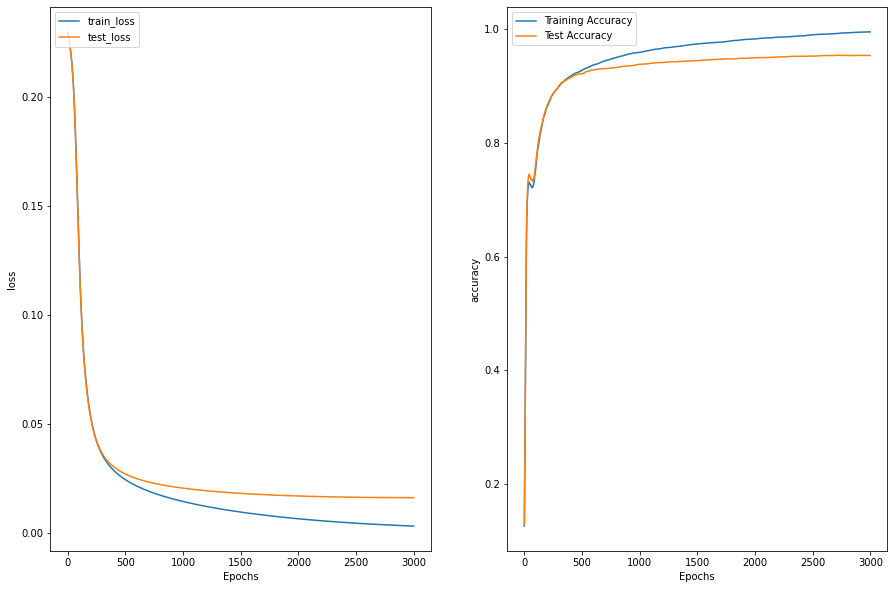

In [25]:
mlp.fit( X_train,y_OH_train, epochs=3000, display_loss=True,test_data=(X_test,y_OH_test))

In [26]:
import sklearn
Y_pred_train = mlp.predict(X_train)
print(Y_pred_train.T.shape)
Y_pred_train = np.argmax(Y_pred_train.T,1)

Y_pred_test = mlp.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test.T,1)

print(Y_pred_train.shape,y_train.shape)
accuracy_train = accuracy_score(Y_pred_train, y_train)
accuracy_test = accuracy_score(Y_pred_test, y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Test Dataset accuracy", round(accuracy_test, 2))
print(sklearn.metrics.classification_report(y_test, Y_pred_test))


(13400, 10)
(13400,) (13400,)
Training accuracy 1.0
Test Dataset accuracy 0.95
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       694
           1       0.96      0.97      0.97       669
           2       0.94      0.96      0.95       642
           3       0.94      0.93      0.94       655
           4       0.97      0.95      0.96       679
           5       0.93      0.95      0.94       617
           6       0.95      0.97      0.96       645
           7       0.96      0.97      0.97       671
           8       0.95      0.92      0.93       665
           9       0.95      0.95      0.95       663

    accuracy                           0.95      6600
   macro avg       0.95      0.95      0.95      6600
weighted avg       0.95      0.95      0.95      6600



# digits that are classified incorrectly.

Incorrectly classfied Digits (304, 784)


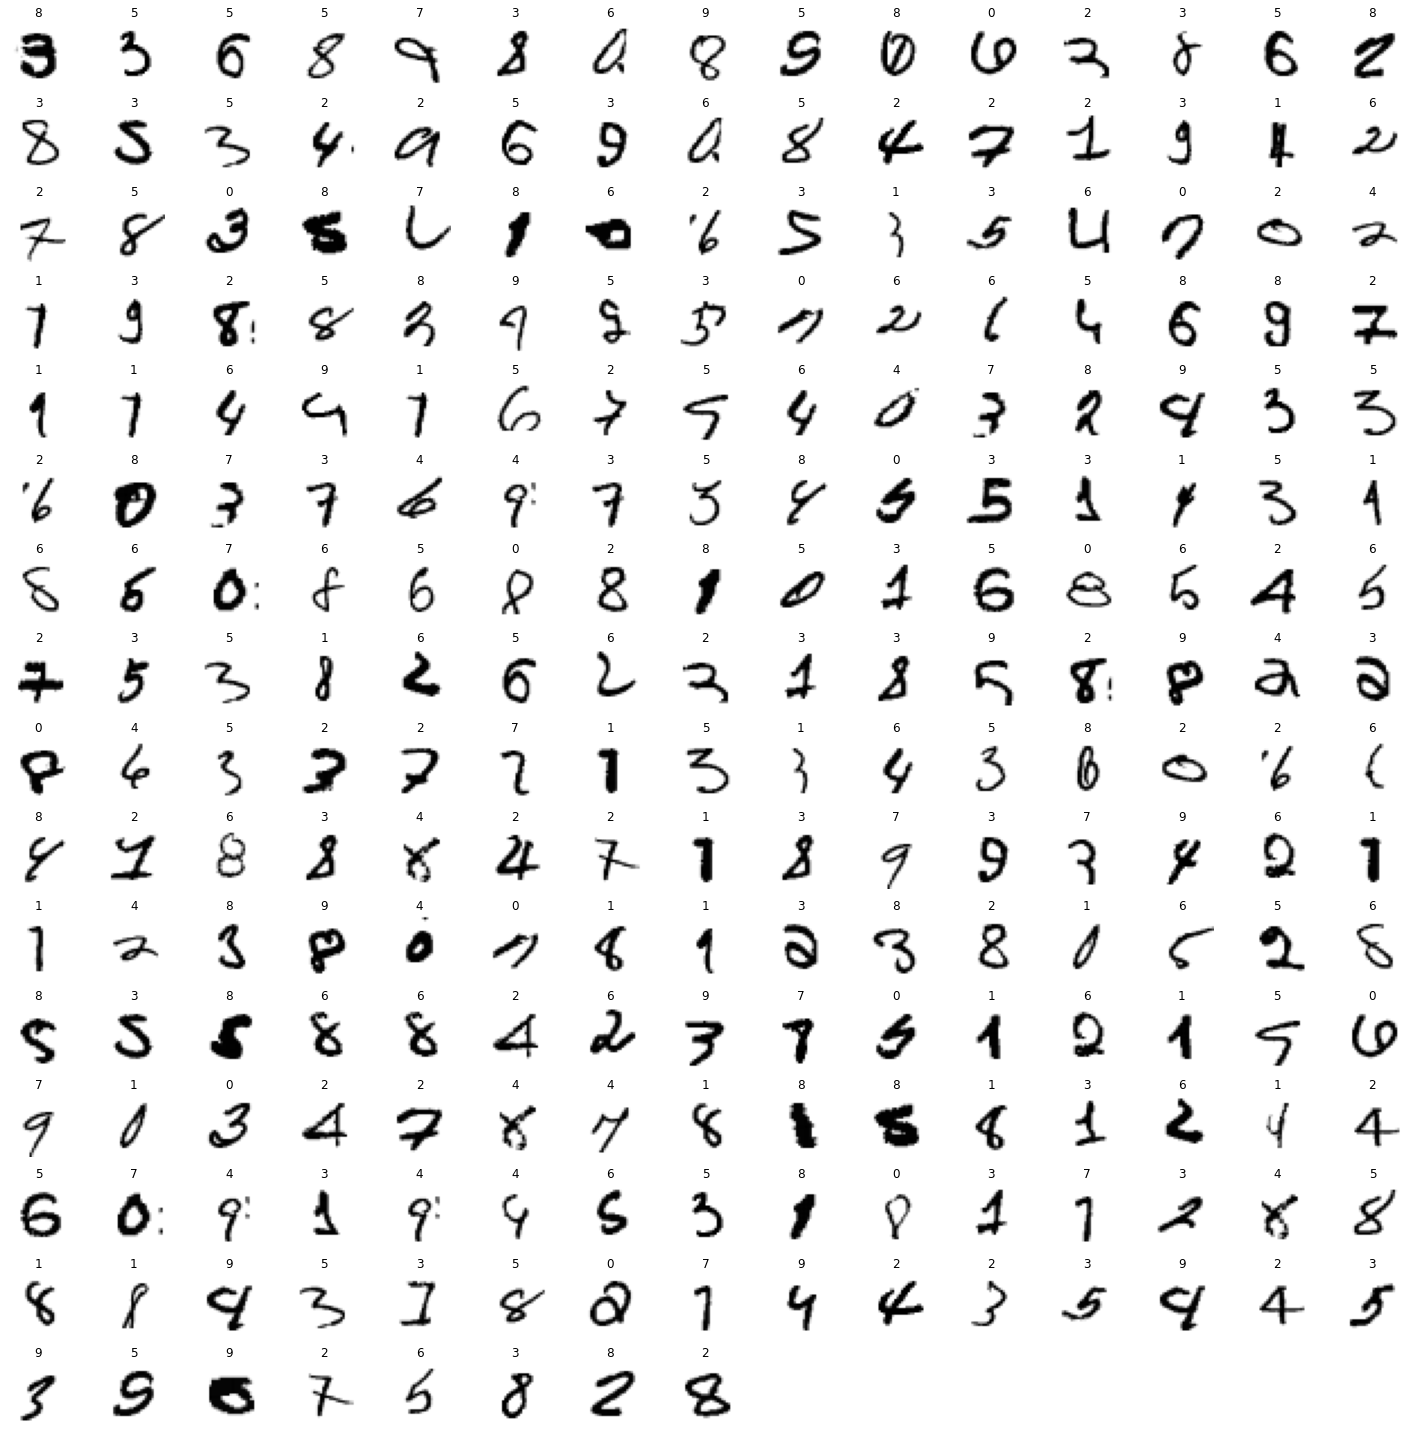

In [27]:
Incorrectly_classfied_images=X_test[Y_pred_test!=y_test].copy()
Incorrectly_classfied_images1=scaler.inverse_transform(Incorrectly_classfied_images)
print('Incorrectly classfied Digits',Incorrectly_classfied_images1.shape)
show_numbers(Incorrectly_classfied_images1,Y_pred_test[Y_pred_test!=y_test])

# First weight layer as a grayscale image.
To scale the weights in range of grayscale image pixel(0,255)
m=(m−rmin)/(rmax−rmin)*(tmax−tmin)+tmin
will scale m linearly into [tmax, tmin] as desired. so here tmax=255, tmin=0 ,rmin  denote the minimum of the range of your weights, rmax denote the maximum of the range of your weights

In [28]:
def show_weights(X):
    num_samples = X.shape[0]
    print(num_samples)
    #indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X

    fig = plt.figure(figsize=(20, 20))
    nu_images=np.round(num_samples/2)
    for i in range(num_samples):
        ax = plt.subplot(20,20, i + 1)
        img = 255 - sample_digits[i].reshape((28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')


400


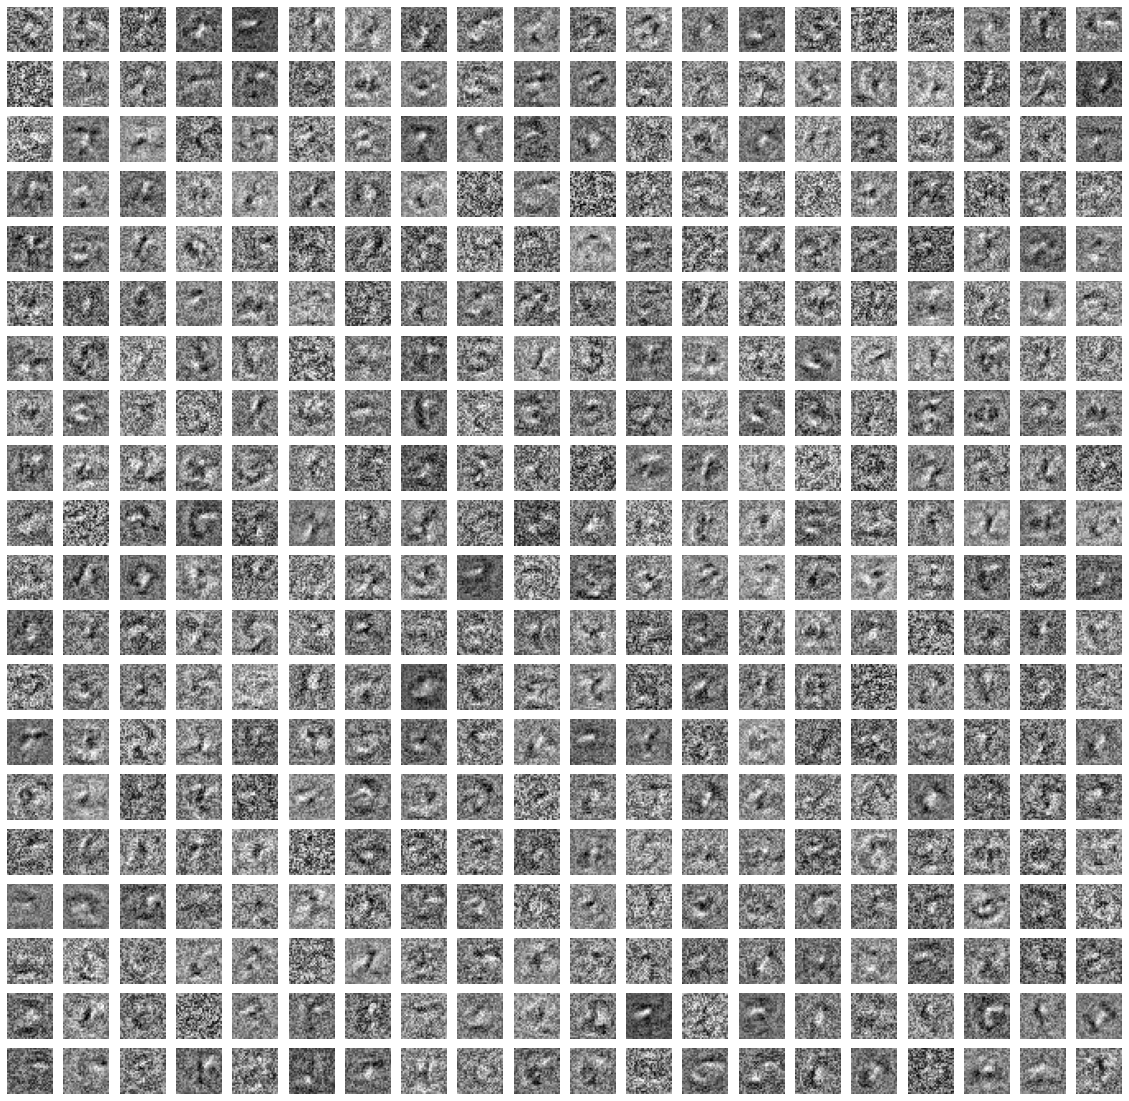

In [29]:
#rescalling values into the grayscale range 0 to 255 
min_value=np.min(mlp.w[1])
max_value=np.max(mlp.w[1])
scaled_value=(mlp.w[1]-min_value)/(max_value-min_value)*255
#plt.imshow(scaled_value.T, cmap="gray") 
#plt.show() 
show_weights(scaled_value)

# Predictions on Test Set

In [30]:
import numpy as np
newarr1 = test_x.reshape(test_x.shape[0], 784)
newarr1=scaler.transform(newarr1)
Y_pred_test = mlp.predict(newarr1)
prediction =Y_pred_test # THAT'S YOUR JOB

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000
print("success")
# AND SAVE EXACTLY AS SHOWN BELOW
#np.save('prediction.npy', prediction)

AssertionError: 